<a href="https://colab.research.google.com/github/HarshJ803/shiny-octo-parakeet/blob/main/Research_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATASET INTRODUCTION
• Source: Yahoo Finance via yfinance Python library
• Companies: Apple (AAPL), Microsoft (MSFT), Amazon (AMZN), Google (GOOGL), Tesla (TSLA)
• Time Span: 2019-01-01 to 2024-01-01
• Features: Date, Open, High, Low, Close, Adj Close, Volume, Ticker

Concise summary stats for each Ticker:


Open                           High                             Low  \
          mean     std    min     max    mean     std     min     max    mean   
Ticker                                                                          
AAPL    122.91   46.51  35.99  198.02  124.32   46.94   36.43  199.62  121.60   
AMZN    127.68   31.30  73.26  187.20  129.24   31.59   76.90  188.65  126.02   
GOOGL    98.13   29.72  51.36  151.25   99.25   30.01   52.50  151.55   97.07   
MSFT    236.16   72.39  99.55  383.76  238.61   73.01  100.19  384.30  233.66   
TSLA    170.94  108.46  12.07  411.47  174.80  110.79   12.45  414.50  166.78   

                ...  Close         Adj Close                         \
           std  ...    min     max      mean     std    min     max   
Ticker          ...                                                   
AAPL     46.09  ...  35.55  198.11    121.25   46.70  34.03  197.59   
AMZN     30.92  ...  75.01  186.57    127.65   31.21  75.01  186.57   
GOOGL    29.40  ...  51.27  149.84     98.08   29.66  51.21  149.67   
MSFT     71.71  ...  97.40  382.70    230.93   73.19  92.15  381.31   
TSLA    105.82  ...  11.93  409.97    170.89  108.30  11.93  409.97   

              Volume                                    
                mean          std       min        max  
Ticker                                                  
AAPL    1.015904e+08  52610869.28  24048300  426510000  
AMZN    7.577451e+07  33520332.68  17626000  311346000  
GOOGL   3.365011e+07  14987636.73   9312000  133178000  
MSFT    2.943760e+07  12362548.06   8989200   97012700  
TSLA    1.340533e+08  85457762.65  29401800  914082000  

[5 rows x 24 columns]

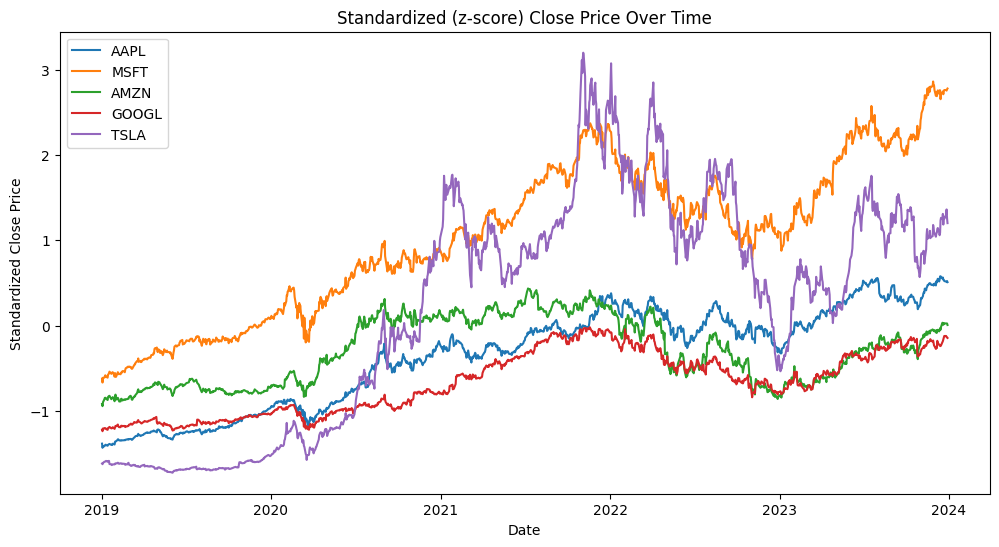

/tmp/ipython-input-1-1356969022.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ticker', y='Close_z', data=df, palette='Set2')


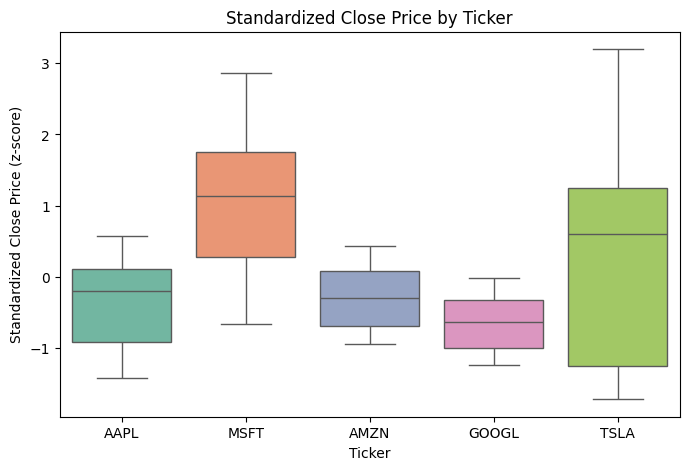

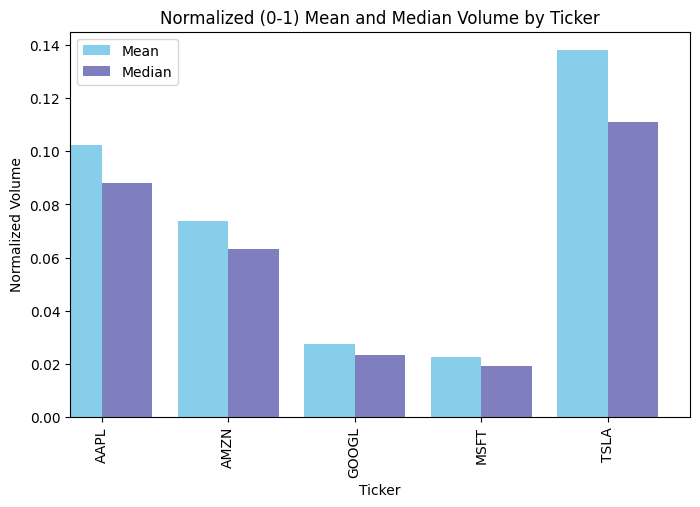

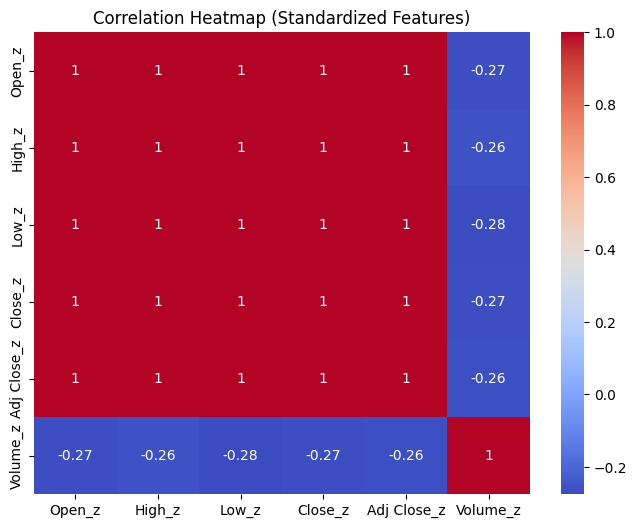

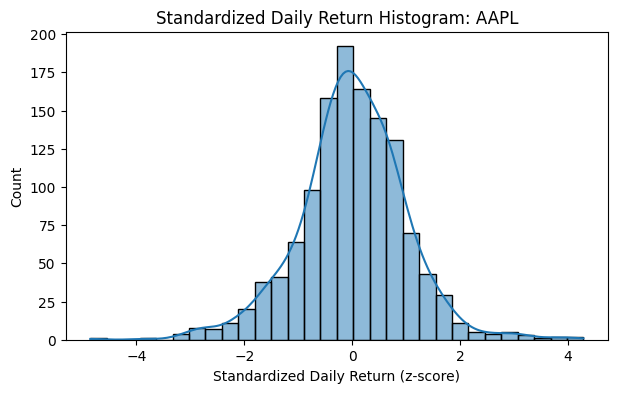

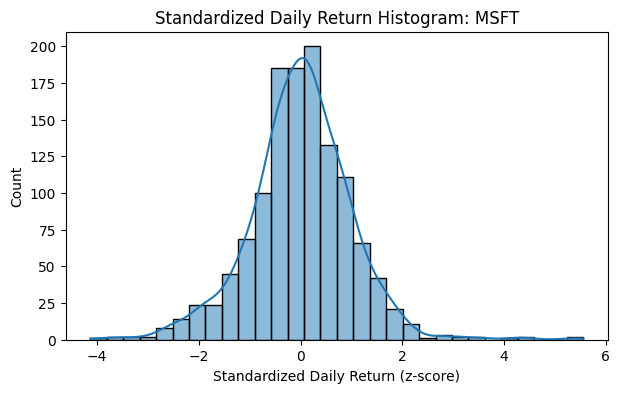

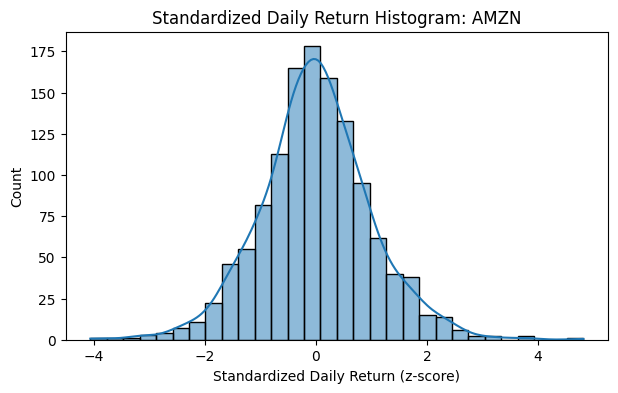

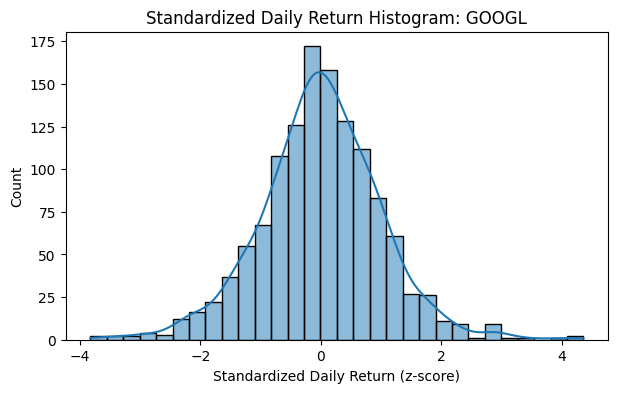

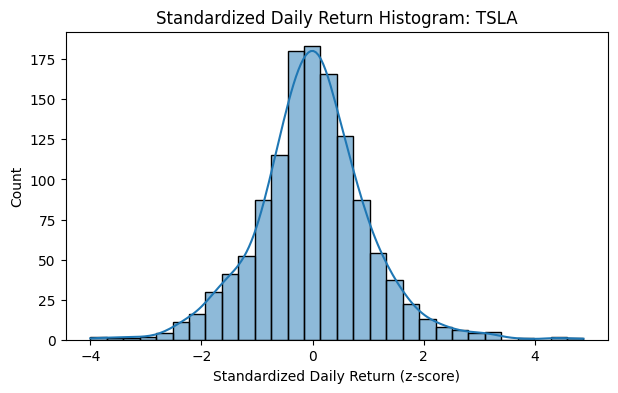

Record High and Low Close Price for Each Ticker:


,Ticker,Record High Date,Record High Close,Record Low Date,Record Low Close
0,AAPL,2023-12-14,198.11,2019-01-03,35.55
1,MSFT,2023-11-28,382.70,2019-01-03,97.40
2,AMZN,2021-07-08,186.57,2019-01-03,75.01
3,GOOGL,2021-11-18,149.84,2019-01-03,51.27
4,TSLA,2021-11-04,409.97,2019-06-03,11.93


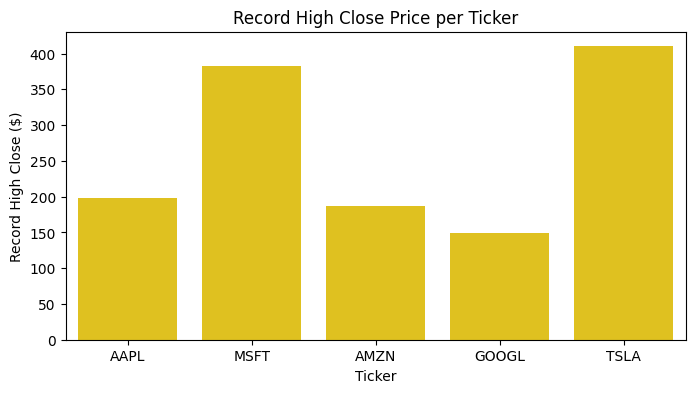

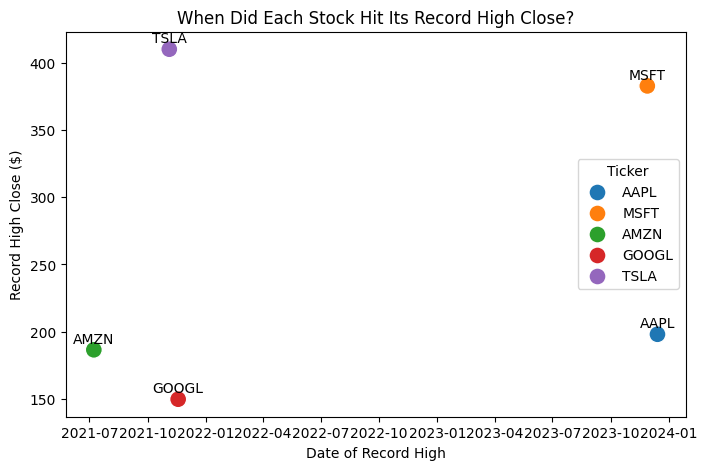

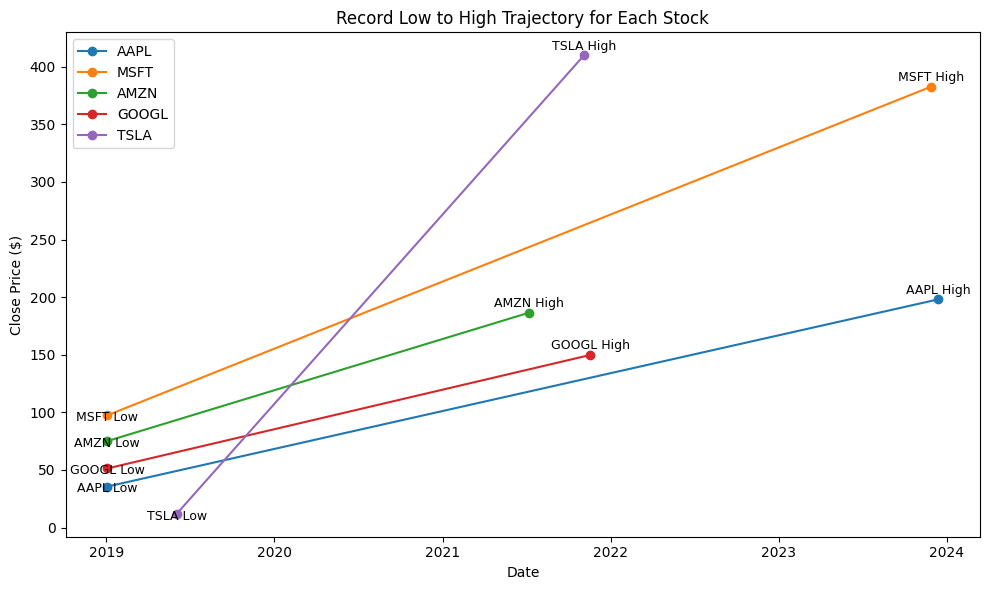

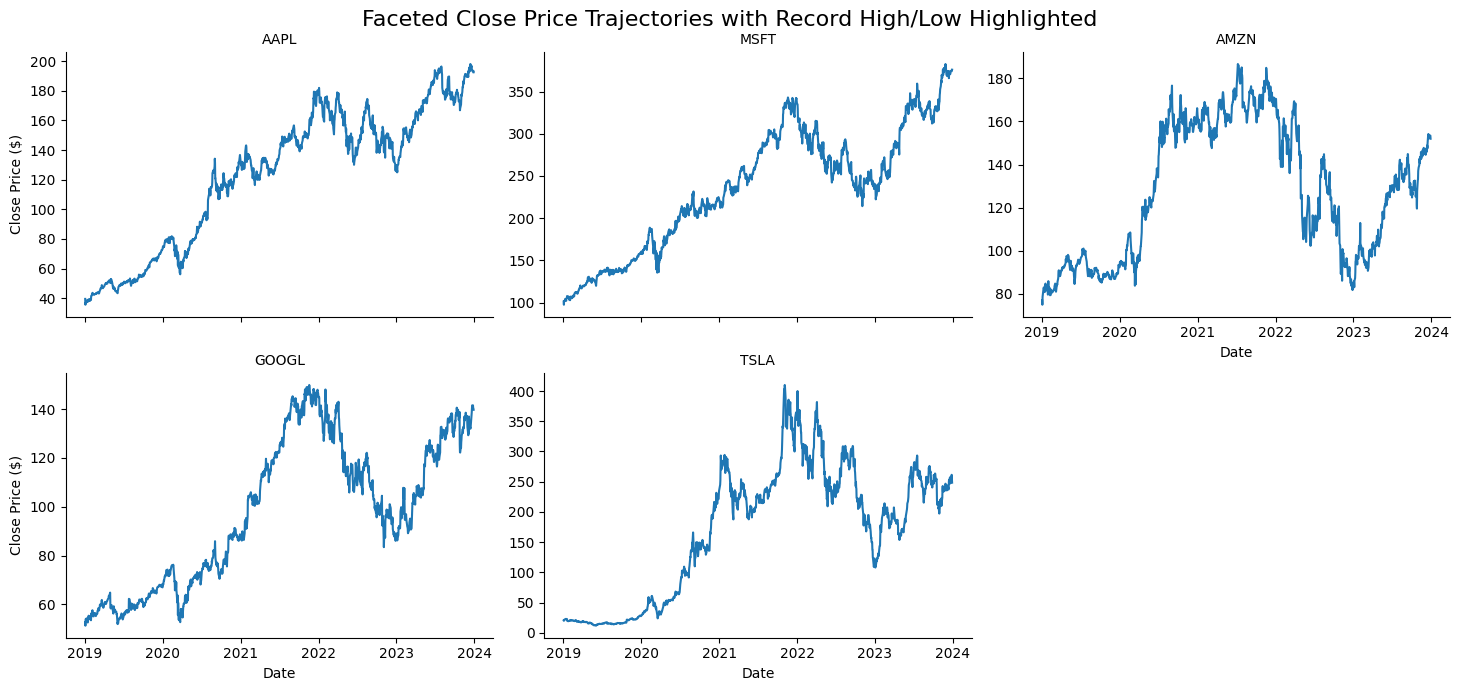

Biggest daily percent gain/drop per ticker (%):


,Ticker,Record Gain Date,Max Gain (%),Record Drop Date,Max Drop (%)
0,AAPL,2022-02-24,6.66,2020-03-20,-7.26
1,MSFT,2022-02-24,8.10,2020-03-20,-5.92
2,AMZN,2022-02-24,8.24,2022-11-01,-6.92
3,GOOGL,2022-11-30,6.51,2020-03-20,-5.54
4,TSLA,2020-02-03,15.78,2021-11-09,-12.79


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Introduce the data
print("="*50)
print("DATASET INTRODUCTION")
print("="*50)
print(
    "• Source: Yahoo Finance via yfinance Python library\n"
    "• Companies: Apple (AAPL), Microsoft (MSFT), Amazon (AMZN), Google (GOOGL), Tesla (TSLA)\n"
    "• Time Span: 2019-01-01 to 2024-01-01\n"
    "• Features: Date, Open, High, Low, Close, Adj Close, Volume, Ticker"
)

# Load data
file_path = '/content/drive/MyDrive/tech-stock-2019-2024 - tech-stock-2019-2024.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

#Concise summary stats table
concise_stats = df[numeric_cols + ['Ticker']].groupby('Ticker').agg(['mean', 'std', 'min', 'max']).round(2)
print("\nConcise summary stats for each Ticker:")
display(concise_stats)

#Data normalization and standardization
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()
for col in numeric_cols:
    df[f'{col}_z'] = scaler_std.fit_transform(df[[col]])
    df[f'{col}_mm'] = scaler_minmax.fit_transform(df[[col]])

# 4. Line plot of Close price vs. Date for each Ticker (z-score)
plt.figure(figsize=(12, 6))
for ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close_z'], label=ticker)
plt.title("Standardized (z-score) Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Standardized Close Price")
plt.legend()
plt.show()

#Boxplots for Close price by Ticker (z-score)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Ticker', y='Close_z', data=df, palette='Set2')
plt.title("Standardized Close Price by Ticker")
plt.ylabel("Standardized Close Price (z-score)")
plt.show()

# chart: mean/median volume by Ticker (normalized)
mean_vol = df.groupby('Ticker')['Volume_mm'].mean()
median_vol = df.groupby('Ticker')['Volume_mm'].median()
plt.figure(figsize=(8, 5))
mean_vol.plot(kind='bar', color='skyblue', width=0.4, position=1, label='Mean')
median_vol.plot(kind='bar', color='navy', width=0.4, position=0, alpha=0.5, label='Median')
plt.title("Normalized (0-1) Mean and Median Volume by Ticker")
plt.ylabel("Normalized Volume")
plt.legend()
plt.show()

#Heatmap of correlations (standardized)
zscore_cols = [f"{col}_z" for col in numeric_cols]
plt.figure(figsize=(8,6))
corr = df[zscore_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Standardized Features)")
plt.show()

#Histogram of daily returns (standardized per ticker)
for ticker in df['Ticker'].unique():
    subset = df[df['Ticker'] == ticker].copy()
    subset['Return'] = (subset['Close'] - subset['Open']) / subset['Open']
    subset['Return_z'] = (subset['Return'] - subset['Return'].mean()) / subset['Return'].std()
    plt.figure(figsize=(7,4))
    sns.histplot(subset['Return_z'], bins=30, kde=True, color='C0')
    plt.title(f"Standardized Daily Return Histogram: {ticker}")
    plt.xlabel("Standardized Daily Return (z-score)")
    plt.show()

# Table of record highs/lows by Ticker
records = []
for ticker in df['Ticker'].unique():
    dft = df[df['Ticker'] == ticker]
    high_row = dft.loc[dft['Close'].idxmax()]
    low_row = dft.loc[dft['Close'].idxmin()]
    records.append([
        ticker,
        high_row['Date'].strftime("%Y-%m-%d"),
        round(high_row['Close'],2),
        low_row['Date'].strftime("%Y-%m-%d"),
        round(low_row['Close'],2)
    ])

records_df = pd.DataFrame(records, columns=['Ticker', 'Record High Date', 'Record High Close',
                                            'Record Low Date', 'Record Low Close'])
print("Record High and Low Close Price for Each Ticker:")
display(records_df)

#Ticker vs Record High Close (bar plot)
plt.figure(figsize=(8,4))
sns.barplot(x='Ticker', y='Record High Close', data=records_df, color='gold')
plt.title("Record High Close Price per Ticker")
plt.ylabel("Record High Close ($)")
plt.xlabel("Ticker")
plt.show()

# 11. Record High Date vs Record High Close (scatter plot)
records_df['Record High Date'] = pd.to_datetime(records_df['Record High Date'])
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='Record High Date',
    y='Record High Close',
    data=records_df,
    hue='Ticker',
    s=150
)
for i, row in records_df.iterrows():
    plt.text(row['Record High Date'], row['Record High Close']+5, row['Ticker'], fontsize=10, ha='center')
plt.title("When Did Each Stock Hit Its Record High Close?")
plt.xlabel("Date of Record High")
plt.ylabel("Record High Close ($)")
plt.show()

# 12. Low-to-High Timeline Plot for Each Ticker
plt.figure(figsize=(10,6))
for i, row in records_df.iterrows():
    plt.plot([pd.to_datetime(row['Record Low Date']), row['Record High Date']],
             [row['Record Low Close'], row['Record High Close']],
             marker='o', label=row['Ticker'])
    plt.text(pd.to_datetime(row['Record Low Date']), row['Record Low Close']-5, f"{row['Ticker']} Low", ha='center', fontsize=9)
    plt.text(row['Record High Date'], row['Record High Close']+5, f"{row['Ticker']} High", ha='center', fontsize=9)
plt.title("Record Low to High Trajectory for Each Stock")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

#FacetGrid for Highs and Lows: Each Company's Close Series
df['is_high'] = False
df['is_low'] = False
for i, row in records_df.iterrows():
    df.loc[(df['Ticker']==row['Ticker']) & (df['Close']==row['Record High Close']), 'is_high'] = True
    df.loc[(df['Ticker']==row['Ticker']) & (df['Close']==row['Record Low Close']), 'is_low'] = True

g = sns.FacetGrid(df, col='Ticker', col_wrap=3, height=3.5, aspect=1.4, sharey=False)
g.map_dataframe(sns.lineplot, x='Date', y='Close')
g.map_dataframe(sns.scatterplot, x='Date', y='Close', hue='is_high', size='is_high',
                sizes={False: 0, True: 200}, palette={True: 'red', False: 'none'}, legend=False)
g.map_dataframe(sns.scatterplot, x='Date', y='Close', hue='is_low', size='is_low',
                sizes={False: 0, True: 200}, palette={True: 'blue', False: 'none'}, legend=False)
g.set_titles("{col_name}")
g.set_axis_labels("Date", "Close Price ($)")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Faceted Close Price Trajectories with Record High/Low Highlighted", fontsize=16)
plt.show()

#Extreme day percent changes: Biggest daily % gain/loss per ticker
records_vol = []
for ticker in df['Ticker'].unique():
    sub = df[df['Ticker'] == ticker].copy()
    sub['Return'] = (sub['Close'] - sub['Open']) / sub['Open']
    max_gain = sub.loc[sub['Return'].idxmax()]
    max_drop = sub.loc[sub['Return'].idxmin()]
    records_vol.append([
        ticker,
        max_gain['Date'].strftime("%Y-%m-%d"),
        round(100*max_gain['Return'],2),
        max_drop['Date'].strftime("%Y-%m-%d"),
        round(100*max_drop['Return'],2)
    ])
records_vol_df = pd.DataFrame(
    records_vol,
    columns=['Ticker', 'Record Gain Date', 'Max Gain (%)', 'Record Drop Date', 'Max Drop (%)'])
print("Biggest daily percent gain/drop per ticker (%):")
display(records_vol_df)

In [ ]:
!pip install numpy==1.26.4 --force-reinstall
import os
os.kill(os.getpid(), 9)  # Forces the Colab runtime to restart so new numpy is active

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# [Install dependencies: pandas-ta, transformers, torch, seaborn]
!pip install pandas-ta transformers torch seaborn --quiet

# [Mount Google Drive for file access]
from google.colab import drive
drive.mount('/content/drive')

# [CSV path — update if you move/rename your file]
news_csv_path = '/content/drive/MyDrive/sample_news  - Sheet1.csv'

import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# [1. LOAD NEWS]
df_news = pd.read_csv(news_csv_path)
df_news.columns = [col.strip() for col in df_news.columns]  # Clean up header names
df_news['EventDate'] = pd.to_datetime(df_news['EventDate'])
df_news['PublishDate'] = pd.to_datetime(df_news['PublishDate'])

# [2. LOAD FINBERT MODEL AND TOKENIZER]
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def finbert_sentiment_score(headlines):
    """Calculate mean sentiment score for list of headlines using FinBERT"""
    scores = []
    for text in headlines:
        inputs = tokenizer(str(text), return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            logits = model(**inputs).logits.detach().numpy()[0]
        score = np.argmax(logits)
        scores.append({0: -1, 1: 0, 2: 1}[score])
    return np.mean(scores) if scores else 0.0

# [3. CALCULATE TECHNICAL INDICATORS FOR ALL TICKERS]
def add_tech_indicators(df):
    """Add technical indicators (SMA, EMA, MACD, RSI, etc.) for each ticker"""
    tickers = df['Ticker'].unique()
    results = []
    for ticker in tickers:
        stock_df = df[df['Ticker'] == ticker].copy().sort_values('Date')
        stock_df = stock_df.set_index('Date')
        stock_df['SMA_14'] = ta.sma(stock_df['Close'], length=14)
        stock_df['EMA_14'] = ta.ema(stock_df['Close'], length=14)
        stock_df['MACD'] = ta.macd(stock_df['Close'])['MACD_12_26_9']
        stock_df['RSI_14'] = ta.rsi(stock_df['Close'], length=14)
        stock_df['ROC_10'] = ta.roc(stock_df['Close'], length=10)
        stock_df['STOCHk'] = ta.stoch(stock_df['High'], stock_df['Low'], stock_df['Close'])['STOCHk_14_3_3']
        bbands = ta.bbands(stock_df['Close'], length=20, std=2)
        stock_df['BB_width'] = bbands['BBU_20_2.0'] - bbands['BBL_20_2.0']
        stock_df['ATR_14'] = ta.atr(stock_df['High'], stock_df['Low'], stock_df['Close'], length=14)
        stock_df['OBV'] = ta.obv(stock_df['Close'], stock_df['Volume'])
        stock_df['VWAP'] = ta.vwap(stock_df['High'], stock_df['Low'], stock_df['Close'], stock_df['Volume'])
        stock_df = stock_df.reset_index()
        results.append(stock_df)
    df_ind = pd.concat(results).sort_values(['Ticker', 'Date']).reset_index(drop=True)
    return df_ind

# [4. PREP STOCK PRICE DATA, CALCULATE INDICATORS]
df['Date'] = pd.to_datetime(df['Date'])   # df = your price dataframe, must be loaded previously
df = df.sort_values(['Ticker', 'Date'])
df_indicators = add_tech_indicators(df)
df_indicators['Return'] = df_indicators.groupby('Ticker')['Close'].pct_change()

# [5. AGGREGATE HEADLINES FOR EACH (TICKER, EVENTDATE)]
# Only headlines with PublishDate == EventDate (no lookahead: strict event day!)
event_rows = []
for (ticker, event_date), grouped in df_news.groupby(['Ticker', 'EventDate']):
    # Only use same-day headlines for this event window
    window = grouped[grouped['PublishDate'] == event_date]
    headlines = list(window['Headline'])
    sentiment = finbert_sentiment_score(headlines)
    # Find the matching row in stock indicators
    price_row = df_indicators[(df_indicators['Ticker'] == ticker) & (df_indicators['Date'] == event_date)]
    if price_row.empty:  # Skip if no matching price
        continue
    row = price_row.iloc[0].to_dict()
    row['Ticker'] = ticker
    row['EventDate'] = event_date
    row['Sentiment'] = sentiment
    row['HeadlineCount'] = len(headlines)
    event_rows.append(row)
    print(f"{ticker} {event_date.date()}: {len(headlines)} headlines, FinBERT sentiment={sentiment:.3f}")

event_sentiment_df = pd.DataFrame(event_rows)

# [6. SELECT MODEL FEATURES]
features = [
    'SMA_14','EMA_14','MACD','RSI_14','ROC_10','STOCHk','BB_width','ATR_14','OBV','VWAP','Sentiment'
]

# [7. TRAIN/PREDICT RANDOM FOREST PER EVENT]
rf_results = []
for idx, event in event_sentiment_df.iterrows():
    ticker = event['Ticker']
    event_date = event['EventDate']
    # 30-day lookback window of technicals for training
    prior_start = event_date - pd.Timedelta(days=30)
    merged = df_indicators[(df_indicators['Ticker'] == ticker)
                           & (df_indicators['Date'] < event_date)
                           & (df_indicators['Date'] >= prior_start)].copy()
    merged['Sentiment'] = event['Sentiment']  # Set event-day sentiment for training rows
    train_df = merged.dropna(subset=features+['Return'])
    X_train = train_df[features]
    y_train = train_df['Return']
    event_row = event[features]
    X_test = pd.DataFrame([event_row])
    y_test = np.array([event['Return']])
    # Only predict if all data present
    if train_df.empty or X_test.isnull().any().any():
        continue
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)[0]
    rf_results.append({
        'Ticker': ticker,
        'EventDate': event_date,
        'ActualReturn': y_test[0],
        'PredictedReturn': pred,
        'HeadlineCount': event['HeadlineCount'],
        'Sentiment': event['Sentiment']
    })

df_rf_event_preds = pd.DataFrame(rf_results)

# [8. PRINT OUT METRICS AND PLOT PER TICKER]
for ticker in df_rf_event_preds['Ticker'].unique():
    sub = df_rf_event_preds[df_rf_event_preds['Ticker'] == ticker].copy().reset_index(drop=True)
    sub['Residual'] = sub['ActualReturn'] - sub['PredictedReturn']
    print(f"\n{ticker} Events - Random Forest Results")
    print(sub[['Ticker', 'EventDate', 'ActualReturn', 'PredictedReturn', 'Sentiment', 'HeadlineCount']].round(4).to_string(index=False))
    print("\nSummary statistics:")
    print(sub[['ActualReturn', 'PredictedReturn', 'Residual']].describe().round(4))
    mae = mean_absolute_error(sub['ActualReturn'], sub['PredictedReturn'])
    rmse = np.sqrt(mean_squared_error(sub['ActualReturn'], sub['PredictedReturn']))
    r2 = r2_score(sub['ActualReturn'], sub['PredictedReturn'])
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.3f}\n")
    # Actual vs. predicted returns: scatterplot for visual inspection
    plt.figure(figsize=(6,5))
    sns.regplot(x=sub['ActualReturn'], y=sub['PredictedReturn'], ci=None, color='teal', marker='o', scatter_kws={'alpha':0.7})
    plt.plot(sub['ActualReturn'], sub['ActualReturn'], color='gray', linestyle='--', label='Perfect prediction')
    plt.title(f'Actual vs. Predicted Return: {ticker}')
    plt.xlabel('Actual Return')
    plt.ylabel('Predicted Return')
    plt.grid(True)
    plt.legend()
    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 847.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.4 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call dr

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

AAPL 2019-01-03: 0 headlines, FinBERT sentiment=0.000
AAPL 2019-01-30: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-02-27: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-02: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-09: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-10: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-12: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-13: 0 headlines, FinBERT sentiment=0.000


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

AAPL 2020-03-16: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-20: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-03-24: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-04-06: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-07-31: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-09-03: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-09-08: 0 headlines, FinBERT sentiment=0.000
AAPL 2020-10-12: 0 headlines, FinBERT sentiment=0.000
AAPL 2022-01-28: 0 headlines, FinBERT sentiment=0.000
AAPL 2022-09-13: 0 headlines, FinBERT sentiment=0.000
AAPL 2022-10-28: 0 headlines, FinBERT sentiment=0.000
AAPL 2022-11-10: 0 headlines, FinBERT sentiment=0.000
AMZN 2020-01-31: 0 headlines, FinBERT sentiment=0.000
AMZN 2020-03-12: 0 headlines, FinBERT sentiment=0.000
AMZN 2020-03-13: 0 headlines, FinBERT sentiment=0.000
AMZN 2020-03-17: 0 headlines, FinBERT sentiment=0.000
AMZN 2020-05-01: 0 headlines, FinBERT sentiment=0.000
AMZN 2020-07-20: 0 headlines, FinBERT sentiment=0.000
AMZN 2021-07-30: 0 headlines